In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

import torch
import torchvision
from torch.utils import data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

random_seed = 1
torch.manual_seed(random_seed)

### Now we have two different datasets (MNIST and SVHN) but in the second one we only have 10 examples per class.

In [2]:
def get_labeled_samples(X, y, n_samples):
    """Returns the labeled samples based on the number of samples defined by the arguments.

    Parameters
    ----------
    X : array_like, shape (n_samples, width, height, channels)
        correspond to the images of the dataset.
    y : array_like, shape (n_samples, )
        correspond to the labels for the images.

    Returns
    ----------
    X_sup : array_like, shape (n_samples, width, height, channels)
           correspond to the images that will be used as the supervised set.
    y_sup : array_like, shape (n_samples, )
            correspond to the labels for the images that will be used as the supervised set.
    n_samples (int): Nuber of samples per class to be labeled.
    """

    np.random.seed(0)

    classes = np.unique(y)
    indxs = [np.where(y == class_) for class_ in classes]

    ix = []
    for indx in indxs:
        ix.extend(np.random.choice(indx[0], n_samples, replace = False))

    np.random.shuffle(ix)
    X_sup = X[ix]
    y_sup = y[ix]

    return X_sup, y_sup, ix


class DigitDataset(data.Dataset):
    """This class is needed to process the batches for the dataloader."""
    def __init__(self, data, target):
        self.data = data
        self.target = target
        self.transform = transforms.Compose([transforms.Resize(32),
                                             transforms.ToTensor()])

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]
        x = Image.fromarray(x)
        x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

    
def get_mnist(data_dir='./data/', batch_size=32):
    train = torchvision.datasets.MNIST(root=data_dir, train=True, download=True)

    x_train = train.data.numpy()
    y_train = train.targets
    
    ## We need to repeat and concatenate the black-and-white images in order to match the 
    ## 3-channel RGB images dimension.
    
    x_train = np.repeat(x_train.reshape(-1, 28, 28, 1), 3, 3)

    dataloader_train = DataLoader(DigitDataset(x_train, y_train), batch_size=batch_size, 
                                shuffle=True, drop_last=True)
    
    return dataloader_train


def get_svhn(data_dir='./data/svhn/', batch_size=32, n_shots=10):
    train = datasets.SVHN(root=data_dir, split='train', download=True)
    test = datasets.SVHN(root=data_dir, split='test', download=True)

    x_train = train.data.transpose(0,2,3,1)
    y_train = train.labels

    x_val, y_val, ixs = get_labeled_samples(x_train, y_train, 1000)
    dataloader_val = DataLoader(DigitDataset(x_val, y_val), batch_size=batch_size, 
                                shuffle=False)

    x_train, y_train = np.delete(x_train, ixs, axis=0), np.delete(y_train, ixs, axis=0)

    x_sup, y_sup, _ = get_labeled_samples(x_train, y_train, n_shots)
    dataloader_sup = DataLoader(DigitDataset(x_sup, y_sup), batch_size=batch_size, 
                                shuffle=True, drop_last=True)

    dataloader_unsup = DataLoader(DigitDataset(x_train, y_train), batch_size=batch_size, 
                                shuffle=True)

    x_test = test.data.transpose(0,2,3,1)
    y_test = test.labels
    dataloader_test = DataLoader(DigitDataset(x_test, y_test), batch_size=batch_size, 
                                shuffle=False)

    return dataloader_sup, dataloader_unsup, dataloader_val, dataloader_test

In [3]:
dataloader_source = get_mnist()
dataloader_sup, dataloader_unsup, dataloader_val, dataloader_test = get_svhn()
images, labels = iter(dataloader_unsup).next()

Using downloaded and verified file: ./data/svhn/train_32x32.mat
Using downloaded and verified file: ./data/svhn/test_32x32.mat


<Figure size 432x288 with 0 Axes>

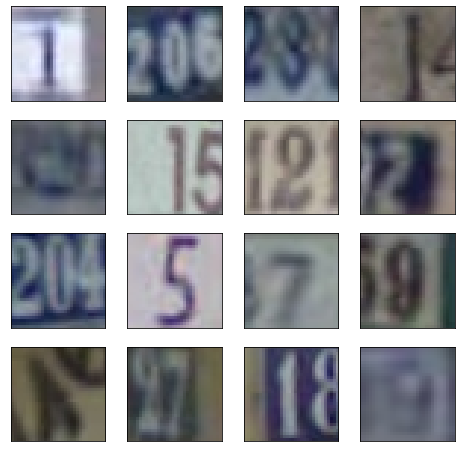

In [4]:
# Plotting some images

N_plots = 4

plt.clf()
fig, axes = plt.subplots(N_plots, N_plots, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i in range(N_plots*N_plots):
    axes.flat[i].imshow(images[i].numpy().transpose(1, 2, 0), interpolation = "nearest")

plt.show()

### Neural Network Architecture

In [5]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class Neural_Network(nn.Module):
    def __init__(self):
        super(Neural_Network, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.softmax(x, -1)

In [6]:
# Some Utilities :D
        
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
class EarlyStopping:
    """Early stopping as the convergence criterion.
        Args:
            args (string): hyperparameters for the training.
            patience (int): the model will stop if it not do improve in a patience number of epochs.
        Returns:
            stop (bool): if the model must stop.
            if_best (bool): if the model performance is better than the previous models.
    """
    def __init__(self, patience=10):
        self.best_metric = 0.0
        self.counter = 0
        self.patience = patience

    def count(self, model, metric):
        is_best = bool(metric > self.best_metric)
        self.best_metric = max(metric, self.best_metric)
        if is_best:
            self.counter = 0
            torch.save(model.state_dict(), './trained_parameters.pth')
        else:
            self.counter += 1
        if self.counter > self.patience:
            stop = True
        else:
            stop = False
        return stop
    
def plot_learning_curves(metric, metric_test, metric_name):
    plt.plot(np.arange(len(metric[0])), metric[0], c='k', label='train')
    plt.plot(np.arange(len(metric[1])), metric[1], c='b', label='val')
    plt.plot(n_epochs-1, metric_test, marker="*", c='r', label='test', markersize=15)
    plt.title('Learning curve {}'.format(metric_name), fontsize=20)
    plt.xlabel('Epoch', fontsize=15)
    plt.ylabel(metric_name, fontsize=15)
    plt.grid(True)
    plt.legend(loc='best', fontsize=15)
    plt.show()

### Supervised Classification

In [7]:
from sklearn.metrics import accuracy_score



def train(n_epochs, dataloader_train, dataloader_val):
    
    es = EarlyStopping()
    cumulated_loss, cumulated_acc = [], []
    cumulated_loss_val, cumulated_acc_val = [], []
    
    for epoch in range(n_epochs):
        loss_metric = AverageMeter()
        acc_metric = AverageMeter()
        print('Epoch: {}/{}'.format(epoch, n_epochs))
        for x, y in dataloader_train:
            model.train()
            x = x.float()
            y = y.long()
            
            out = model(x)

            loss = F.cross_entropy(out, y)
            #Computing gradients
            loss.backward()
            optimizer.step()
            
            y_pred = np.argmax(out.detach().numpy(), axis=1)
            
            loss_metric.update(loss.item(), x.size(0))
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))
            #Zero grading for next iteration.
            optimizer.zero_grad()

        print('Training loss: {:.2f}, Accuracy: {:.2f}'.format(
                                                    loss_metric.avg, acc_metric.avg))
        cumulated_loss.append(loss_metric.avg)
        cumulated_acc.append(acc_metric.avg)
        
        loss_val, acc_val = evaluate(model, dataloader_val)
        stop = es.count(model, acc_val)
        cumulated_loss_val.append(loss_val)
        cumulated_acc_val.append(acc_val)
        
    return (cumulated_loss, cumulated_loss_val), (cumulated_acc, cumulated_acc_val)


def evaluate(model, dataloader):
    """Evalute the unsupervised model."""
    model.eval()
    loss_metric = AverageMeter()
    acc_metric = AverageMeter()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float()
            y = y.long()

            out = model(x)

            loss = F.cross_entropy(out, y)
            y_pred = np.argmax(out.detach().numpy(), axis=1)
            
            loss_metric.update(loss.item(), x.size(0))
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))

    print('Test loss: {:.2f}, Accuracy: {:.2f}'.format(loss_metric.avg, acc_metric.avg))
    return loss_metric.avg, acc_metric.avg

In [8]:
#Hyperparameters

learning_rate = 0.001
n_epochs = 15

model = Neural_Network()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Epoch: 0/15
Training loss: 2.30, Accuracy: 0.10
Test loss: 2.30, Accuracy: 0.10
Epoch: 1/15
Training loss: 2.30, Accuracy: 0.12
Test loss: 2.30, Accuracy: 0.10
Epoch: 2/15
Training loss: 2.30, Accuracy: 0.10
Test loss: 2.30, Accuracy: 0.10
Epoch: 3/15
Training loss: 2.30, Accuracy: 0.10
Test loss: 2.30, Accuracy: 0.10
Epoch: 4/15
Training loss: 2.30, Accuracy: 0.09
Test loss: 2.30, Accuracy: 0.10
Epoch: 5/15
Training loss: 2.30, Accuracy: 0.14
Test loss: 2.30, Accuracy: 0.09
Epoch: 6/15
Training loss: 2.30, Accuracy: 0.15
Test loss: 2.30, Accuracy: 0.09
Epoch: 7/15
Training loss: 2.30, Accuracy: 0.08
Test loss: 2.30, Accuracy: 0.10
Epoch: 8/15
Training loss: 2.30, Accuracy: 0.12
Test loss: 2.30, Accuracy: 0.10
Epoch: 9/15
Training loss: 2.30, Accuracy: 0.09
Test loss: 2.30, Accuracy: 0.10
Epoch: 10/15
Training loss: 2.30, Accuracy: 0.12
Test loss: 2.30, Accuracy: 0.10
Epoch: 11/15
Training loss: 2.30, Accuracy: 0.08
Test loss: 2.30, Accuracy: 0.10
Epoch: 12/15
Training loss: 2.30, Accu

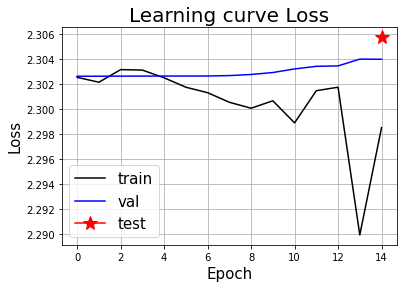

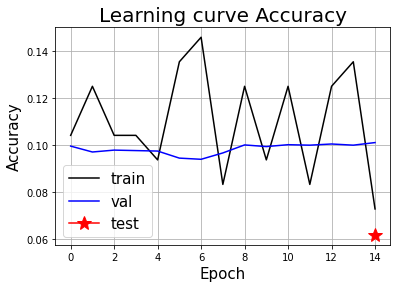

In [9]:
loss, acc = train(n_epochs, dataloader_sup, dataloader_val)
loss_test_sup, acc_test_sup = evaluate(model, dataloader_test)

plot_learning_curves(loss, loss_test_sup, 'Loss')
plot_learning_curves(acc, acc_test_sup, 'Accuracy')

### Supervised Domain Adaptation: Fine-tunning

Epoch: 0/15
Training loss: 2.30, Accuracy: 0.09
Test loss: 2.30, Accuracy: 0.10
Epoch: 1/15
Training loss: 2.30, Accuracy: 0.11
Test loss: 2.30, Accuracy: 0.10
Epoch: 2/15
Training loss: 2.30, Accuracy: 0.07
Test loss: 2.30, Accuracy: 0.10
Epoch: 3/15
Training loss: 2.30, Accuracy: 0.17
Test loss: 2.30, Accuracy: 0.10
Epoch: 4/15
Training loss: 2.30, Accuracy: 0.15
Test loss: 2.30, Accuracy: 0.10
Epoch: 5/15
Training loss: 2.30, Accuracy: 0.14
Test loss: 2.30, Accuracy: 0.10
Epoch: 6/15
Training loss: 2.30, Accuracy: 0.16
Test loss: 2.30, Accuracy: 0.10
Epoch: 7/15
Training loss: 2.30, Accuracy: 0.14
Test loss: 2.30, Accuracy: 0.11
Epoch: 8/15
Training loss: 2.30, Accuracy: 0.14
Test loss: 2.30, Accuracy: 0.10
Epoch: 9/15
Training loss: 2.30, Accuracy: 0.15
Test loss: 2.30, Accuracy: 0.10
Epoch: 10/15
Training loss: 2.29, Accuracy: 0.12
Test loss: 2.30, Accuracy: 0.10
Epoch: 11/15
Training loss: 2.29, Accuracy: 0.11
Test loss: 2.30, Accuracy: 0.11
Epoch: 12/15
Training loss: 2.29, Accu

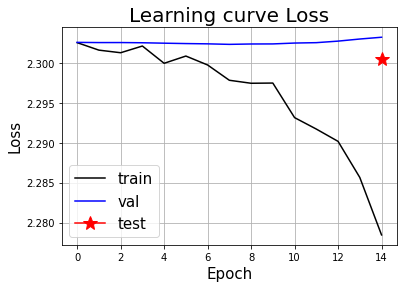

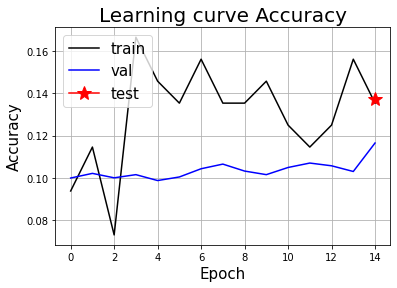

In [10]:
model = Neural_Network()
model.load_state_dict(torch.load('./trained_parameters_mnist.pth'))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss, acc = train(n_epochs, dataloader_sup, dataloader_val)
loss_test_fine, acc_test_fine = evaluate(model, dataloader_test)

plot_learning_curves(loss, loss_test_fine, 'Loss')
plot_learning_curves(acc, acc_test_fine, 'Accuracy')

### Unsupervised Domain Adaptation: Adversarial Discriminative Domain Adaptation

In [11]:
import torch
import torch.nn as nn
from torch.autograd import Function


class GradientReverse(torch.autograd.Function):
    scale = 1.0
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return GradientReverse.scale * grad_output.neg()
    
def grad_reverse(x, scale=1.0):
    GradientReverse.scale = scale
    return GradientReverse.apply(x)

#Now we need a feature extractor and a classifier.

class ADDA(nn.Module):
    def __init__(self):
        super(ADDA, self).__init__()
        #Feature extractor
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        
        #Domain Classifier
        self.fc1 = nn.Linear(500, 50)
        self.fc2 = nn.Linear(50, 2)
        
        #Class classifier
        self.fc3 = nn.Linear(500, 50)
        self.fc4 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        
        rev_x = grad_reverse(x)
        domain_out = F.relu(self.fc1(rev_x))
        domain_out = F.softmax(self.fc2(domain_out), -1)
        
        class_out = F.dropout(F.relu(self.fc3(x)), p=0.5)
        class_out = F.softmax(self.fc4(class_out), -1)       
        return domain_out, class_out
    
def trainADDA(n_epochs,  dataloader_source, dataloader_target, 
             dataloader_va):
    
    cumulated_loss, cumulated_loss_val = [], []
    
    for epoch in range(n_epochs):
        loss_metric = AverageMeter()
        print('Epoch: {}/{}'.format(epoch, n_epochs))
        for iteration in range(n_iters):
            if iteration % len(dataloader_source) == 0:
                iter_source = iter(dataloader_source)
            if iteration % len(dataloader_target) == 0:
                iter_target = iter(dataloader_target)
            x_s, y_s = next(iter_source)
            x_t, _ = next(iter_target)
            
            x_s = x_s.float()
            y_s = y_s.long()
            x_t = x_t.float()
            
            model.train()
            
            #######################
            # Source Forward Pass #
            ########################
            
            s_label = torch.zeros(x_s.size(0))
            s_label = s_label.long()
            
            domain_out_s, class_out = model(x_s)
            l_class_s = F.cross_entropy(class_out, y_s)
            l_dom_s = F.cross_entropy(domain_out_s, s_label)

            #######################
            # Target Forward Pass #
            ########################
            t_label = torch.ones(x_t.size(0))
            t_label = t_label.long()
            
            domain_out_t, _ = model(x_t)
            l_dom_t = F.cross_entropy(domain_out_t, t_label)
            
            loss = l_class_s + l_dom_s + l_dom_t
            
            loss.backward()
            optimizer.step()
                        
            loss_metric.update(loss)
            #Zero grading for next iteration.
            optimizer.zero_grad()

        print('Training Loss: {:.2f}'.format(loss_metric.avg))
        cumulated_loss.append(loss_metric.avg)
        
        loss_val, _ = evaluateADDA(model, dataloader_val)
        cumulated_loss_val.append(loss_val)
        
    return cumulated_loss, cumulated_loss_val

def evaluateADDA(model, dataloader):
    """Evalute the unsupervised model."""
    model.eval()
    loss_metric = AverageMeter()
    acc_metric = AverageMeter()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float()
            y = y.long()
            
            dom_label = torch.ones(x.size(0))
            dom_label = dom_label.long()

            domain_out, class_out = model(x)
            l_class = F.cross_entropy(class_out, y)
            l_dom = F.cross_entropy(domain_out, dom_label)
            
            loss = l_class + l_dom
            
            y_pred = np.argmax(class_out.detach().numpy(), axis=1)
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))
            
            loss_metric.update(loss)

    print('Test Loss: {:.2f}; Accuracy: {:.2f}'.format(loss_metric.avg, acc_metric.avg))
    return loss_metric.avg, acc_metric.avg

Epoch: 0/20
Training Loss: 3.67
Test Loss: 2.93; Accuracy: 0.10
Epoch: 1/20
Training Loss: 3.67
Test Loss: 3.03; Accuracy: 0.10
Epoch: 2/20
Training Loss: 3.66
Test Loss: 2.95; Accuracy: 0.10
Epoch: 3/20
Training Loss: 3.68
Test Loss: 2.98; Accuracy: 0.10
Epoch: 4/20
Training Loss: 3.68
Test Loss: 2.92; Accuracy: 0.10
Epoch: 5/20
Training Loss: 3.72
Test Loss: 2.97; Accuracy: 0.10
Epoch: 6/20
Training Loss: 3.59
Test Loss: 2.98; Accuracy: 0.10
Epoch: 7/20
Training Loss: 3.59
Test Loss: 3.04; Accuracy: 0.10
Epoch: 8/20
Training Loss: 3.49
Test Loss: 3.12; Accuracy: 0.10
Epoch: 9/20
Training Loss: 3.64
Test Loss: 3.11; Accuracy: 0.10
Epoch: 10/20
Training Loss: 3.71
Test Loss: 3.00; Accuracy: 0.10
Epoch: 11/20
Training Loss: 3.77
Test Loss: 2.90; Accuracy: 0.10
Epoch: 12/20
Training Loss: 3.62
Test Loss: 2.90; Accuracy: 0.10
Epoch: 13/20
Training Loss: 3.69
Test Loss: 2.97; Accuracy: 0.10
Epoch: 14/20
Training Loss: 3.69
Test Loss: 2.97; Accuracy: 0.10
Epoch: 15/20
Training Loss: 3.70
Te

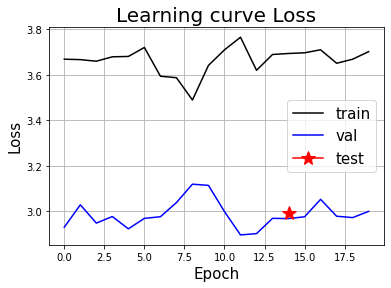

In [12]:
n_epochs = 20

model = ADDA()

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

loss = trainADDA(n_epochs,  dataloader_source, dataloader_unsup, 
                  dataloader_val)

loss_test_adda, acc_test_adda = evaluateADDA(model, dataloader_test)
plot_learning_curves(loss, loss_test_adda, 'Loss')

### Semi-supervised Domain Adaptation via Minimax Entropy (MME)

In [13]:
#Now we need a feature extractor and a classifier.

class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.fc1 = nn.Linear(500, 50)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = x.view(-1, 500)
        return F.relu(self.fc1(x))
    
class Classifier(nn.Module):
    def __init__(self, temperature):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(50, 10, bias=False)
        self.T = temperature

    def forward(self, x, grad_rev=False, eta=1.0):
        if grad_rev:
            x = grad_reverse(x, eta)
        x = F.normalize(x)
        x_out = self.fc(x) / self.T
        return x_out

    
def adentropy(out):
    """Adentropy loss for the MME minimax optimization."""
    out = F.softmax(out, dim=1)
    adentropy = 0.1 * torch.mean(torch.sum(out * torch.log(out + 1e-10), dim=1))
    return adentropy


# rebuilding the training module

def trainMME(n_epochs,  dataloader_source, dataloader_sup, 
          dataloader_unsup, dataloader_val):
    
    es = EarlyStopping()
    cumulated_acc, cumulated_acc_val = [], []
    
    for epoch in range(n_epochs):
        acc_metric = AverageMeter()
        print('Epoch: {}/{}'.format(epoch, n_epochs))
        for iteration in range(n_iters):
            if iteration % len(dataloader_source) == 0:
                iter_source = iter(dataloader_source)
            if iteration % len(dataloader_sup) == 0:
                iter_sup = iter(dataloader_sup)
            if iteration % len(dataloader_unsup) == 0:
                iter_unsup = iter(dataloader_unsup)
            x_s, y_s = next(iter_source)
            x_sup, y_sup = next(iter_sup)
            x_unsup, _ = next(iter_unsup)
            
            x = torch.cat((x_s, x_sup), dim=0)
            y = torch.cat((y_s, y_sup), dim=0)
            x = x.float()
            y = y.long()
            x_unsup = x_unsup.float()
            
            FtrExt.train()
            Clf.train()
            
            #############################
            # CrossEntropy Minimization #
            #############################
            
            x_out = FtrExt(x)
            pred_s = Clf(x_out)
            l_xent = F.cross_entropy(pred_s, y)

            l_xent.backward(retain_graph=True)
            optimizer_f.step()
            optimizer_c.step()
            
            ################
            # Minimax Loss #
            #################
            optimizer_f.zero_grad()
            optimizer_c.zero_grad()
            
            x_out = FtrExt(x_unsup)
            pred_u = Clf(x_out, grad_rev=True)
            l_t = adentropy(pred_u)

            l_t.backward()
            optimizer_f.step()
            optimizer_c.step()
            
            y_pred = np.argmax(pred_s.detach().numpy(), axis=1)
            
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))
            #Zero grading for next iteration.
            optimizer_f.zero_grad()
            optimizer_c.zero_grad()

        print('Training Accuracy: {:.2f}'.format(acc_metric.avg))
        cumulated_acc.append(acc_metric.avg)
        
        acc_val = evaluateMME(FtrExt, Clf, dataloader_val)
        stop = es.count(model, acc_val)
        cumulated_acc_val.append(acc_val)
        
    return cumulated_acc, cumulated_acc_val

def evaluateMME(FtrExt, Clf, dataloader):
    """Evalute the semi-supervised model."""
    FtrExt.eval()
    Clf.eval()
    acc_metric = AverageMeter()
    with torch.no_grad():
        for x, y in dataloader:
            x = x.float()
            y = y.long()

            x_out = FtrExt(x)
            out = Clf(x_out)

            loss = F.cross_entropy(out, y)
            y_pred = np.argmax(out.detach().numpy(), axis=1)
            
            acc_metric.update(accuracy_score(y, y_pred), x.size(0))

    print('Test Accuracy: {:.2f}'.format(acc_metric.avg))
    return acc_metric.avg

Epoch: 0/20
Training Accuracy: 0.10
Test Accuracy: 0.10
Epoch: 1/20
Training Accuracy: 0.10
Test Accuracy: 0.10
Epoch: 2/20
Training Accuracy: 0.10
Test Accuracy: 0.10
Epoch: 3/20
Training Accuracy: 0.10
Test Accuracy: 0.10
Epoch: 4/20
Training Accuracy: 0.10
Test Accuracy: 0.10
Epoch: 5/20
Training Accuracy: 0.11
Test Accuracy: 0.10
Epoch: 6/20
Training Accuracy: 0.12
Test Accuracy: 0.10
Epoch: 7/20
Training Accuracy: 0.13
Test Accuracy: 0.10
Epoch: 8/20
Training Accuracy: 0.13
Test Accuracy: 0.10
Epoch: 9/20
Training Accuracy: 0.19
Test Accuracy: 0.11
Epoch: 10/20
Training Accuracy: 0.14
Test Accuracy: 0.10
Epoch: 11/20
Training Accuracy: 0.17
Test Accuracy: 0.09
Epoch: 12/20
Training Accuracy: 0.25
Test Accuracy: 0.12
Epoch: 13/20
Training Accuracy: 0.31
Test Accuracy: 0.14
Epoch: 14/20
Training Accuracy: 0.33
Test Accuracy: 0.13
Epoch: 15/20
Training Accuracy: 0.39
Test Accuracy: 0.17
Epoch: 16/20
Training Accuracy: 0.49
Test Accuracy: 0.21
Epoch: 17/20
Training Accuracy: 0.64
Test

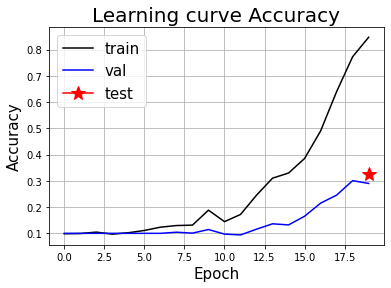

In [14]:
n_epochs = 20

FtrExt = FeatureExtractor()
FtrExt.load_state_dict(torch.load('./trained_parameters_mnist.pth'), strict=False)
Clf = Classifier(temperature=0.1)

optimizer_f = torch.optim.SGD(FtrExt.parameters(), lr=0.01, momentum=0.9,
                               weight_decay=0.0005, nesterov=True)
optimizer_c = torch.optim.SGD(Clf.parameters(), lr=0.1, momentum=0.9,
                               weight_decay=0.0005, nesterov=True)

acc = trainMME(n_epochs,  dataloader_source, dataloader_sup, 
                  dataloader_unsup, dataloader_val)
acc_test_mme = evaluateMME(FtrExt, Clf, dataloader_test)
plot_learning_curves(acc, acc_test_mme, 'Accuracy')

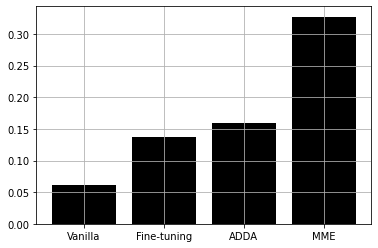

In [31]:
accuracies = [acc_test_sup, acc_test_fine, acc_test_adda, acc_test_mme]
names = ['Vanilla', 'Fine-tuning', 'ADDA', 'MME']
plt.bar(names, accuracies, color='k')
plt.grid()
plt.show()